## Running CellART on VisiumHD colorectal cancer dataset

### Download data

The VisiumHD colorectal cancer dataset can be obtained from the 10x Genomics website [here](https://www.10xgenomics.com/cn/datasets/visium-hd-cytassist-gene-expression-libraries-of-human-colorectal-cancer-tissue), with name “Visium HD, Sample P2 CRC”. Below is a demo script for create new data dir and download the required VisiumHD files. 

In [ ]:
mkdir ./visiumhd_crc
cd ./visiumhd_crc

curl -O https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Colon_Cancer_P2/Visium_HD_Human_Colon_Cancer_P2_tissue_image.btf
curl -O https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Colon_Cancer_P2/Visium_HD_Human_Colon_Cancer_P2_alignment_file.json
curl -O https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Colon_Cancer_P2/Visium_HD_Human_Colon_Cancer_P2_binned_outputs.tar.gz
curl -O https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Colon_Cancer_P2/Visium_HD_Human_Colon_Cancer_P2_spatial.tar.gz

# Unzip files
tar -xzvf Visium_HD_Human_Colon_Cancer_P2_binned_outputs.tar.gz
tar -xzvf Visium_HD_Human_Colon_Cancer_P2_spatial.tar.gz

# Back to root dir
cd ..

After unzip the file, you will get binned_outputs and spatial directory. The paired scRNA reference after selecting patient 2 can be download [here](https://drive.google.com/file/d/1kzNZq7h4V-JyaBcjJ1Kcz-JSlLFNAQrY/view?usp=drive_link). Please also download the reference file adata_sc_p2.h5ad into the data directory. Now you have prepared all the raw data to run CellART.

### Preprocess

In [ ]:
from cellart.utils.preprocess import SingleCellPreprocessor, VisiumHDPreprocessor
from cellart.utils.io import load_list
import scanpy as sc

# Processed data save dir
save_dir = './preprocessed_visiumhd_crc/'
# Path to 002um spot data
path = "./visiumhd_crc/binned_outputs/square_002um/"
# Path to he
source_image_path = "./visiumhd_crc/Visium_HD_Human_Colon_Cancer_P2_tissue_image.btf"
# Path to spatial dir
spaceranger_image_path = "./visiumhd_crc/spatial/"

st_preprocessor = VisiumHDPreprocessor(path, source_image_path, spaceranger_image_path, save_dir)
st_preprocessor.get_nuclei_segmentation()
sc_adata = sc.read("./visiumhd_crc/adata_sc_p2.h5ad")
sc_preprocessor = SingleCellPreprocessor(sc_adata, celltype_col = "celltype", save_path= save_dir, st_gene_list=load_list(save_dir + "/st_gene_list.txt"))
sc_preprocessor.preprocess(hvg_method="seurat_v3", n_hvg=3000)
st_preprocessor.prepare_sst(load_list(save_dir + "/filtered_gene_names.txt"))

Now in the preprocessed_crc directory, you can see all the preprocessed files. You can check the spatial and segmentation files to see if their are matched.

In [ ]:
# Check
import numpy as np
import matplotlib.pyplot as plt

gene_map = np.load(save_dir + "/gene_map.npy")
segmentation_mask = np.load(save_dir + "/segmentation_mask.npy")

gene_map_sum = gene_map.sum(axis=-1)

In [ ]:
# plt.imshow(gene_map_sum)
# plt.imshow(segmentation_mask > 0)
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].imshow(gene_map_sum)
ax[0].set_title("Gene expression map sum")
ax[1].imshow(segmentation_mask > 0)
ax[1].set_title("Nuclei segmentation mask")
plt.show()

### Running CellART

NOTE: these part code make takes hours to run, so it is highly recommend you not to directly run in the notebook.

In [ ]:
import cellart
from pathlib import Path
import wandb
import os

# Preprocessed data
save_dir = './preprocessed_visiumhd_crc/'
# Directory to store all results
log_dir = "./results_visiumhd_crc/"

manager = cellart.ExperimentManager(
    # Basic input data settings (must be specified)
    gene_map=os.path.join(save_dir, "gene_map.npy"),
    nuclei_mask=os.path.join(save_dir, "segmentation_mask.npy"),
    basis=os.path.join(save_dir, "basis.npy"),
    gene_names=os.path.join(save_dir, "filtered_gene_names.txt"),
    celltype_names=os.path.join(save_dir, "celltype_names.txt"),
    log_dir=log_dir,

    # Training parameters (adjust based on convergence and wandb visualization)
    epoch=400, 
    seg_training_epochs=15,
    deconv_warmup_epochs=200,

    pred_period=50,
    gpu="0"
)

# Update options
opt = manager.get_opt()
print(opt)

In [ ]:
# Set up wandb for logging and visualization
run = wandb.init(project="CellART", dir=manager.get_log_dir(), config=opt,
                 name=os.path.basename(os.path.normpath(manager.get_log_dir())))

In [ ]:
# Set up dataset
dataset = cellart.SSTDataset(manager)
gene_map_shape = dataset.gene_map.shape

# Initialize and train the CellART model
model = cellart.CellARTModel(manager, gene_map_shape, len(dataset.coords_starts))
model.train_model(dataset)

### Check the output of CellART

In [3]:
# Load annotated adata at epoch 400
adata = sc.read(os.path.join("./results_visiumhd_crc/", "epoch_400", "cell_deconv.h5ad"))
# Load segmentation
segmentation_mask = np.load(os.path.join("./results_visiumhd_crc/", "new_segmentation_mask.npy")).astype("int32")

In [4]:
adata.obs.head()

x    y              celltype
cell_id                                
209338   389   19  CD8 Cytotoxic T cell
209346   360   25                Plasma
209365   344  320            CD4 T cell
209383   351  321            CD4 T cell
209404   391   30           Endothelial

In [5]:
segmentation_mask.shape, np.unique(segmentation_mask)

((3350, 3350),
 array([     0,      1,      2, ..., 263669, 263670, 263671], dtype=int32))

In [6]:
celltype_mapping = {
    'CAF': '#117733',  # Green
    'CD4 T cell': '#88CCEE',  # Light Blue
    'CD8 Cytotoxic T cell': '#CC6677',  # Pink
    'Endothelial': '#DDCC77',  # Sand Yellow
    'Enteric Glial': '#332288',  # Dark Blue
    'Enterocyte': '#AA4499',  # Purple
    'Epithelial': '#44AA99',  # Teal
    'Fibroblast': '#999933',  # Olive
    'Goblet': '#A1C935',  # Lime
    'Lymphatic Endothelial': '#661100',  # Brown
    'Macrophage': '#6699CC',  # Sky Blue
    'Mast': '#AA4466',  # Rose
    'Mature B': '#888888',  # Gray
    'Myofibroblast': '#117755',  # Forest Green
    'Neuroendocrine': '#332299',  # Indigo
    'Neutrophil': '#D95F02',  # Replaced duplicate pink
    'Pericytes': '#1B9E77',  # Replaced duplicate teal
    'Plasma': '#E6AB02',  # Replaced duplicate olive
    'Proliferating Immune II': '#882255',  # Burgundy
    'SM Stress Response': '#66C2A5',  # Replaced duplicate blue
    'Smooth Muscle': '#A6761D',  # Replaced duplicate brown
    'Tuft': '#7570B3',  # Replaced duplicate green
    'Tumor I': '#E7298A',  # Replaced duplicate coral
    'Tumor II': '#6A3D9A',  # Replaced duplicate navy
    'Tumor III': '#FFA500',  # Orange
    'Tumor V': '#FFD92F',  # Replaced duplicate mustard
    'Unknown III (SM)': '#B2DF8A',  # Replaced duplicate green
    'mRegDC': '#1F78B4',  # Replaced duplicate blue
    'pDC': '#8C510A',  # Replaced duplicate brown
    'vSM': '#5AB4AC',  # Replaced duplicate jade green
    "Unassigned": "lightgray",
}

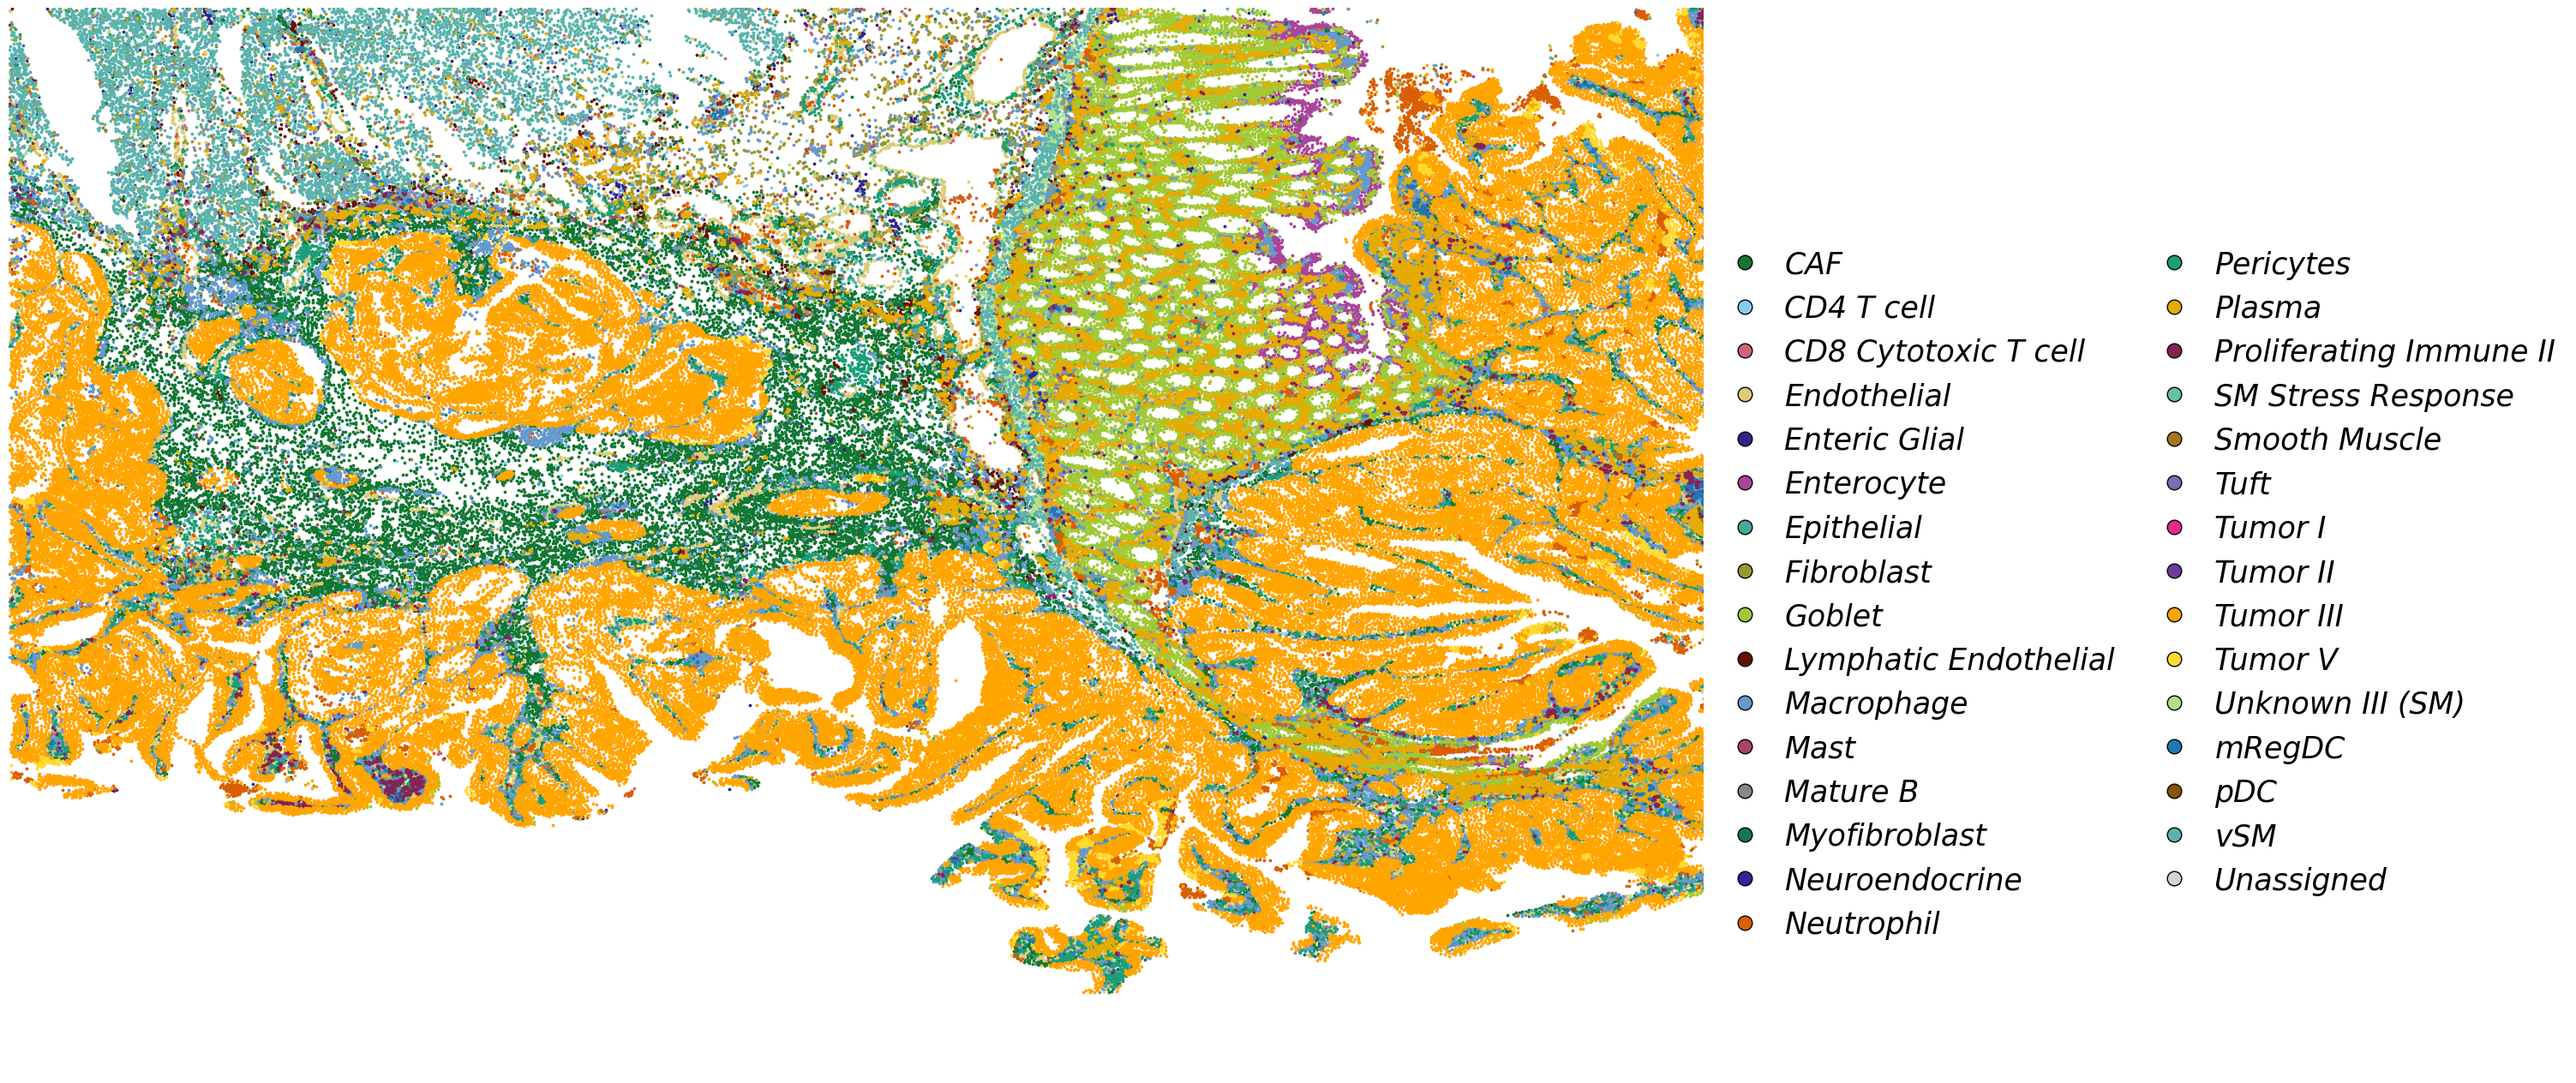

In [10]:
# Visualization of cell types
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 4, figsize=(30, 15))
gs = GridSpec(1, 4, figure=fig)

for ax_ in ax.flatten():
    fig.delaxes(ax_)

ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3])

celltype_names = list(celltype_mapping.keys())
# selected_celltype = ["Tumor II", "Tumor III", "Tumor V"]
selected_celltype = celltype_names
selected_celltype = celltype_names
for i in range(len(celltype_names)):
    # (0,0) is on the top left corner
    if celltype_names[i] not in selected_celltype:
        continue
    sub_df = adata[adata.obs["celltype"] == celltype_names[i - 1]].obs
    ax1.scatter(sub_df["y"], sub_df["x"], s=3, label=celltype_names[i - 1], color=celltype_mapping[celltype_names[i - 1]])
# ax1.invert_yaxis()
ax1.axis("off")
ax1.set_xlim(adata.obs["x"].min(), adata.obs["x"].max())
ax1.set_ylim(adata.obs["y"].min(), adata.obs["y"].max())
ax1.invert_yaxis()

# Add legend elements (example)
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='None',
        color='w',
        label=label,
        markerfacecolor=color,
        markeredgecolor='k',
        markersize=12
    ) for label, color in celltype_mapping.items()
]

# Add the legend below the entire figure, centered horizontally with [0, 1] subfigures
ax2.legend(
    handles=legend_elements,
    loc='center',                    # Center the legend within the bounding box
    bbox_to_anchor=(0.48, 0.45),       # Center of ax2 (0.5, 0.5 is the middle of the axis)
    ncol=2,                          # Number of columns for the legend
    handletextpad=0.35,               # Spacing between marker and text
    columnspacing=1,               # Spacing between legend columns
    prop={'size': 25, 'style': 'italic'},  # Font size and style
    frameon=False                    # No border for the legend
)

ax2.axis("off")  # Hide the axis for ax2
# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.15, 1, 1])  # Leave space for the legend below the plots
plt.show()

In [ ]:
from spatialdata_io import visium_hd
from cellart.utils.spatialdata_utils import append_visiumhd_boundary
import spatialdata_plot
from shapely.geometry import Polygon
from shapely.ops import unary_union
import geopandas as gpd
import spatialdata as sd

sdata_hd = visium_hd("./visiumhd_crc/")

/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
append_visiumhd_boundary(
    segmentation_mask = segmentation_mask,
    spot_id_map = os.path.join('./preprocessed_visiumhd_crc/', "spot_id_map.npy"),
    sdata = sdata_hd,
    shape_key = "Visium_HD_Human_Colon_Cancer_P2_square_002um",
    new_shape_key = "cellart_seg",
    celltype= adata.obs["celltype"]
)

/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_794928/2510591147.py:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_re.obs["seg"] = segmentation_flat
/tmp/ipykernel_794928/2510591147.py:34: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sdata.tables[f'square_002um_{new_shape_key}'].obs["seg"] = sdata.tables[f'square_002um_{new_shape_key}'].obs["seg"].astype(
/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [ ]:
x_min, x_max, y_min, y_max = 59550, 61050, 700, 2100

sdata_roi = sdata_hd.query.bounding_box(
    min_coordinate=[x_min, y_min], max_coordinate=[x_max, y_max], axes=("x", "y"), target_coordinate_system="global"
)

# Create boundary 
gdf = gpd.GeoDataFrame(columns=['geometry','seg', 'celltype'])

for cell_id in sdata_roi.shapes["cellart_seg"]["cellart_seg"].unique():
    cell = sdata_roi.shapes["cellart_seg"][sdata_roi.shapes["cellart_seg"]["cellart_seg"] == cell_id]
    cell = cell.geometry.tolist()
    merged = unary_union(cell)
    try:
        outer_boundary = merged.exterior
    except:
        continue
    gdf.loc[len(gdf)] = [Polygon(outer_boundary), cell_id, sdata_roi.shapes["cellart_seg"][sdata_roi.shapes["cellart_seg"]["cellart_seg"] == cell_id].celltype.unique()[0]]
gdf = sd.models.ShapesModel.parse(gdf)
sdata_roi.shapes["cellart_boundary"] = gdf
sdata_roi.shapes["cellart_boundary"]["seg"] = sdata_roi.shapes["cellart_boundary"]["seg"].astype("category")
sdata_roi.shapes["cellart_boundary"]["celltype"] = sdata_roi.shapes["cellart_boundary"]["celltype"].astype("category")

ct_col = sdata_roi.shapes["cellart_boundary"].celltype
cts = sdata_roi.shapes["cellart_boundary"].celltype.unique()
for ct in cts:
    sdata_roi.shapes[f"cellart_boundary_{ct.replace(' ', '_').replace('(', '').replace(')', '')}"] = sdata_roi.shapes["cellart_boundary"][ct_col == ct]

/home/yhchenmath/anaconda3/envs/cellseg/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Value for parameter 'color' appears to be a color, using it as 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


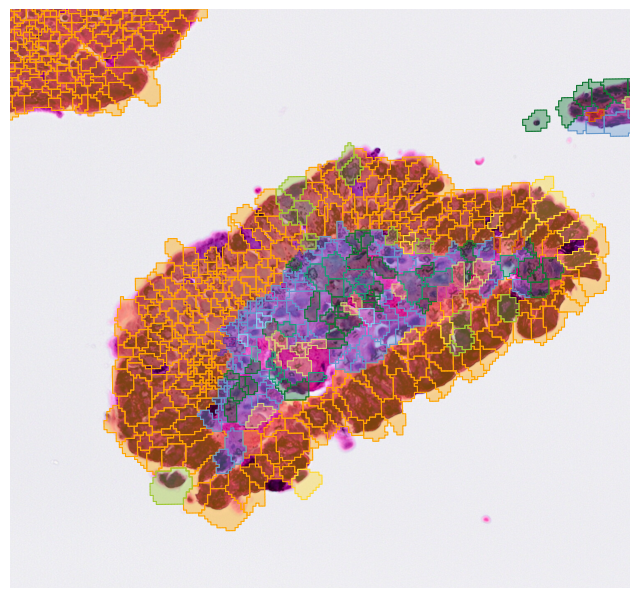

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))


tmp = sdata_roi.pl.render_images(
     "Visium_HD_Human_Colon_Cancer_P2_full_image")
draw_cts = sdata_roi.shapes["cellart_boundary"].celltype.unique().tolist()
for ct in draw_cts:
    color = celltype_mapping[ct]
    tmp = tmp.pl.render_shapes(
        f"cellart_boundary_{ct.replace(' ', '_').replace('(', '').replace(')', '')}",
        color=color, fill_alpha=0.4, outline_width=0.8, outline_color = color, outline_alpha=1
    )
tmp.pl.show(coordinate_systems="global", ax=ax, title="", frameon=False, legend_loc='none')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.axis("off")
plt.show()